In [1]:
# import pydot, graphviz
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, concatenate, GlobalAveragePooling2D, Reshape
from tensorflow.keras.layers import Permute
from keras.utils import to_categorical
from keras.models import Model
from tensorflow.keras.applications import ResNet50
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras import Model
import torch
from transformers import ViTFeatureExtractor, ViTModel
from torchvision.models import vision_transformer
from keras.callbacks import ModelCheckpoint


2024-06-19 11:37:37.328087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 11:37:37.328221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 11:37:37.462518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
mapping = {
    "1_chongkong" : 0,
    "2_hanfeng" : 1,
    "3_yueyawan": 2,
    "4_shuiban": 3,
    "5_youban": 4,
    "6_siban": 5,
    "7_yiwu": 6,
    "9_zhehen": 7,
    "10_yaozhed": 8,
    "scratches": 9,
    "rolled-in_scale": 10,
    "8_yahen": 11,
    "inclusion" :6

}
mapping2 = {
    0 : "Punching Hole",
    1 : "Welding Line",
    2 : "Crescent Gap",
    3 : "Water Spot",
    4 : "Oil Spot",
    5 : "Silk Spot",
    6 : "Inclusion",
    11 : "Rolled Pit",
    7 : "Crease",
    8 : "Waist Folding",
    9 : "Scratches",
    10 : "Rolled in Scale"
}

In [3]:
X = []
y = []
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

In [4]:
w_factor = 2048/224.0
l_factor = 1000/224.0
w = 224
l = 224
w_factor_2 = 200/224.0
l_factor_2 = 200/224.0

In [5]:
def get_annotations(directory, class_name, idx):

    try:
        tree = ET.parse(directory)
        root = tree.getroot()
        boxes = []
        defect = -1
        objs = root.findall('object')
        for i in objs:
            name = i.find('name').text
            defect = mapping.get(name, 12)
            if defect != 12 and defect != 11:
                box = i.find('bndbox')
                xmin = float(box.find('xmin').text)
                ymin = float(box.find('ymin').text)
                xmax = float(box.find('xmax').text)
                ymax = float(box.find('ymax').text)

               
                if xmin > xmax:
                    temp = xmin
                    xmin = xmax
                    xmax = temp
                if ymin > ymax:
                    temp = ymin
                    ymin = ymax
                    ymax = temp

                box = []
                for i in range(5):
                    box.append(-1)
                box[0] = defect
                if class_name !='inclusion':
                    box[1] = (xmin)/w_factor
                    box[2] = (ymin)/l_factor
                    box[3] = (xmax)/w_factor
                    box[4] = (ymax)/l_factor
                elif (class_name=='inclusion' and idx<217):
                    box[1] = (xmin)/w_factor
                    box[2] = (ymin)/l_factor
                    box[3] = (xmax)/w_factor
                    box[4] = (ymax)/l_factor
                
                elif (class_name=='inclusion' and idx>= 217):
                    box[1] = (xmin)/w_factor_2
                    box[2] = (ymin)/l_factor_2
                    box[3] = (xmax)/w_factor_2
                    box[4] = (ymax)/l_factor_2
                    
                boxes.append(box)
            else:
                defect = -1
        if boxes:
            return boxes
        print(class_name, idx)
        return 0
    except:
        return 0

In [6]:
get_annotations('/kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/lable/inclusion (3).xml', 'inclusion', 3)

[[6, 185.28125, 46.592, 188.890625, 53.76],
 [2, 97.015625, 165.536, 122.71875, 224.0]]

In [7]:
print(get_annotations("/kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/lable/crease (1).xml",'crease', 1 ))

[[7, 107.296875, 40.768, 223.78125, 55.775999999999996], [7, 52.28125, 40.096, 77.765625, 54.656]]


In [8]:
# os.listdir('/kaggle/input/metal-surfaces-defects/Metal-surfaces-defects')

In [9]:
data_dir= "/kaggle/input/metal-surfaces-defects/Metal-surfaces-defects"

In [10]:
len(os.listdir(data_dir))

13

In [11]:
all_items = os.listdir(data_dir)
categories = [item for item in all_items if os.path.isdir(os.path.join(data_dir, item)) and item != 'lable']
print(categories)

['inclusion', 'rolled_pit', 'oil_spot', 'crescent_gap', 'crease', 'waist_folding', 'rolled_in_scale', 'scratches', 'water_spot', 'punching_hole', 'silk_spot', 'welding_line']


In [12]:
sample_images=[]

In [13]:
for category in categories:
    category_path= os.path.join(data_dir, category)
    for img in os.listdir(category_path):
        img_path= os.path.join(category_path, img)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (100, 100))
        sample_images.append(img)
        break

In [14]:
fig = plt.figure(figsize=(15, 15))
spec = gridspec.GridSpec(ncols=3, nrows=4,
                         width_ratios=[1, 1, 1], wspace=0.4,
                         hspace=0.4, height_ratios=[1, 1, 1, 1])
fig.suptitle("Sample images for 11 classes")

Text(0.5, 0.98, 'Sample images for 11 classes')

<Figure size 1500x1500 with 0 Axes>

In [15]:
for i in range(len(sample_images)):
    ax = fig.add_subplot(3, 4, i+1)
    ax.imshow(sample_images[i], cmap='gray')
    ax.set_title(f"{categories[i]}")  

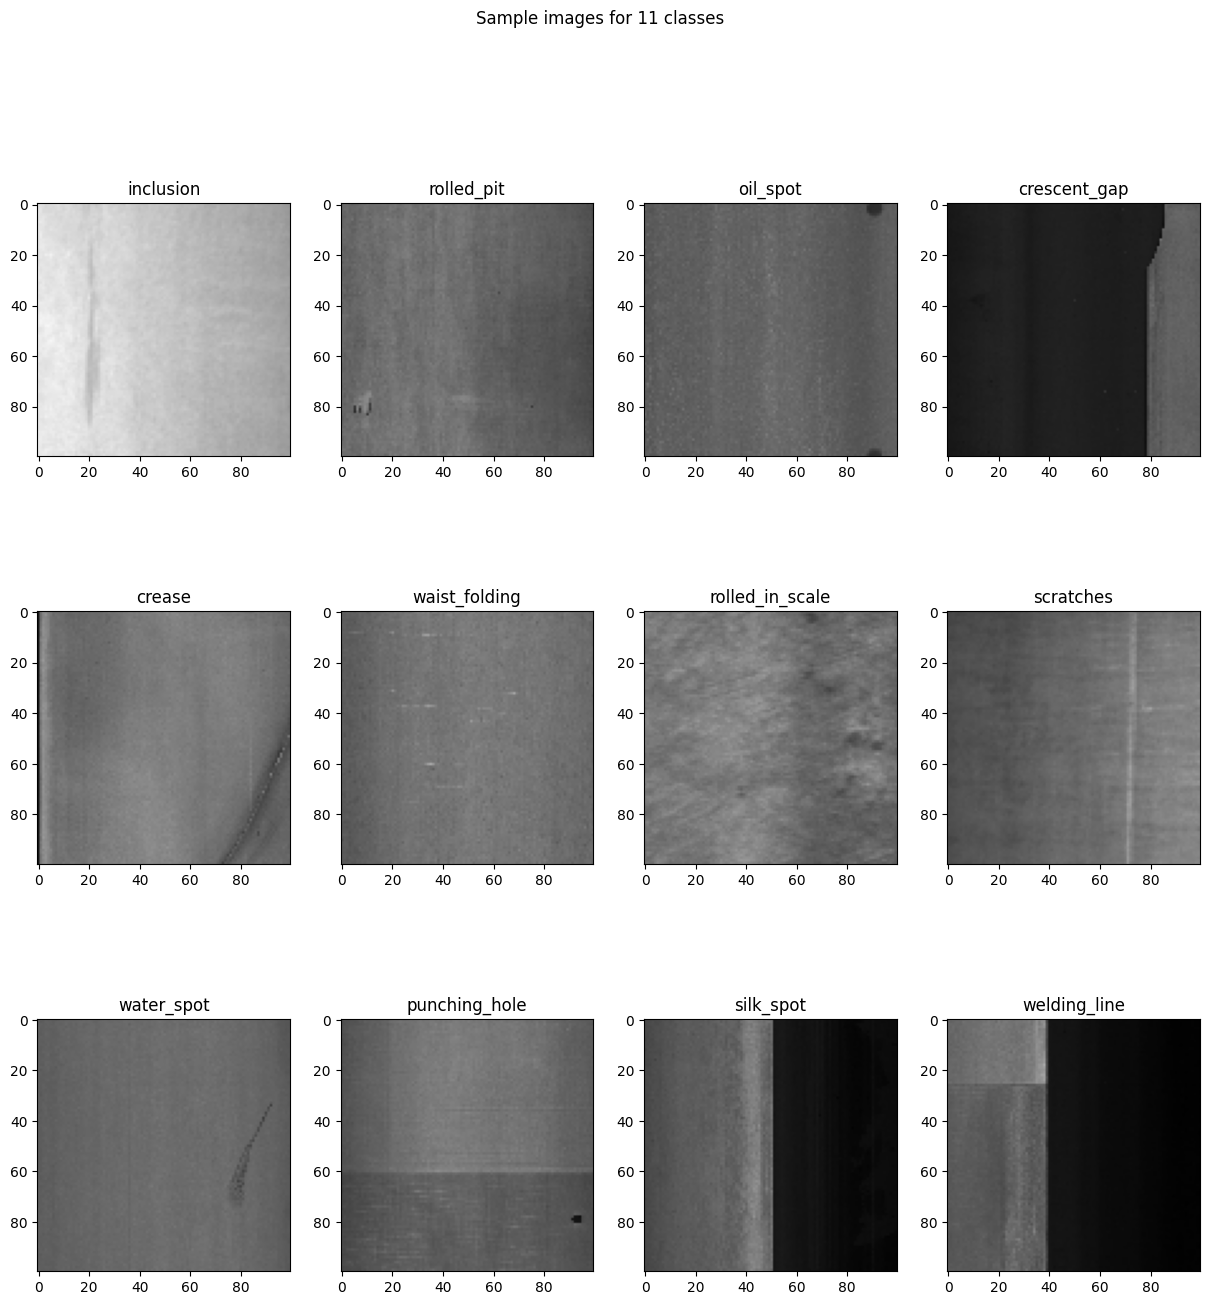

In [16]:
fig

In [17]:
f=0
for category in categories:
    category_path= os.path.join(data_dir, category)
    cnt=1
    if (f):
        break
    for img in os.listdir(category_path):
        img_path= os.path.join(category_path, img)
        img= cv2.imread(img_path)
        annotation = get_annotations(f"/kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/lable/{category} ({cnt}).xml", category, cnt)
        cnt+=1
        if (len(X)==900):
            f=1
            break
        if (annotation):
            img = cv2.resize(img, (w, l))
#             img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#             img= np.expand_dims(img, axis=0)
            X.append(img)
            y.append(annotation)
            


inclusion 59
inclusion 124
rolled_pit 1
rolled_pit 3
rolled_pit 4
rolled_pit 5
rolled_pit 6
rolled_pit 7
rolled_pit 8
rolled_pit 9
rolled_pit 10
rolled_pit 11
rolled_pit 12
rolled_pit 13
rolled_pit 14
rolled_pit 16
rolled_pit 17
rolled_pit 18
rolled_pit 19
rolled_pit 20
rolled_pit 21
rolled_pit 22
rolled_pit 23
rolled_pit 24
rolled_pit 25
rolled_pit 26
rolled_pit 27
rolled_pit 29
rolled_pit 30


In [18]:
len(X)

900

In [19]:
len(y)

900

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [21]:
y_train[0][0][0]

6

In [22]:
def split_gt(y):
    classes = []
    dims = []
    for i in range(len(y)):
        tmp_classes = []
        tmp_dims = []
        for j in range(len(y[i])):
            tmp_classes.append(y[i][j][0])
            tmp_dims.append(y[i][j][1:])
        classes.append(tmp_classes)
        dims.append(tmp_dims)
    return classes, dims

In [23]:
classes_train, dims_train = split_gt(y_train)
classes_val, dims_val = split_gt(y_val)
classes_test, dims_test = split_gt(y_test)

In [24]:
# classes_train

In [25]:
# dims_train

In [26]:
def xyxy2xywh(dims):
    new_dims = []
    for i in range(len(dims)):
        new_dims.append([])
        for j in range(len(dims[i])):
            xmin = dims[i][j][0]
            ymin = dims[i][j][1]
            width = dims[i][j][2] - dims[i][j][0]
            height = dims[i][j][3] - dims[i][j][1]
            new_dims[i].append([xmin, ymin, width, height])
    return new_dims

In [27]:
dims_train = xyxy2xywh(dims_train)

In [28]:
dims_train

[[[7.84, 2.2399999999999998, 36.959999999999994, 218.39999999999998],
  [48.16, 85.11999999999999, 26.879999999999995, 98.55999999999999],
  [128.79999999999998, 25.759999999999998, 20.159999999999997, 61.6],
  [77.28, 108.64, 22.39999999999999, 33.59999999999998]],
 [[88.921875, 1.568, 22.421875, 21.503999999999998],
  [17.0625, 122.52799999999999, 33.6875, 69.66400000000002],
  [184.625, 71.232, 26.359375, 22.623999999999995]],
 [[97.78125, 150.304, 29.859375, 73.696],
  [1.421875, 212.352, 109.59375, 11.199999999999989]],
 [[209.125, 144.256, 9.515625, 14.111999999999995],
  [195.125, 169.12, 21.984375, 51.29599999999999]],
 [[96.140625, 92.736, 12.140625, 28.671999999999997]],
 [[187.04, 92.96, 36.96000000000001, 13.439999999999998],
  [1.1199999999999999, 184.79999999999998, 151.2, 28.0],
  [164.64, 187.04, 30.24000000000001, 17.919999999999987]],
 [[185.0625, 135.296, 5.03125, 7.391999999999996],
  [180.578125, 167.552, 4.703125, 8.063999999999993],
  [182.0, 180.54399999999998, 

In [29]:
# for i in range(len(dims_train)):
#     for j in range(len(dims_train[i])):
#         for k in range(len(dims_train[i][j])):
#                 dims_train[i][j][k] =dims_train[i][j][k]/ 169.203125

In [30]:
X= np.array(X, dtype = 'float')
X_train = np.array(X_train, dtype = 'float')
X_test = np.array(X_test, dtype = 'float')
X_val = np.array(X_val, dtype = 'float')

In [31]:
def extract_min(lst, index):
    minn = 10000000
    for i in range(len(lst)):
        for j in range(len(lst[i])):
            if lst[i][j][index] < minn:
                minn = lst[i][j][index]
    return minn

def extract_max(lst, index):
    maxx = -10000000
    for i in range(len(lst)):
        for j in range(len(lst[i])):
            if lst[i][j][index] > maxx:
                maxx = lst[i][j][index]
    return maxx

In [32]:
def maxminscaler(lst, maxx, minn, index):
    for i in range(len(lst)):
        for j in range(len(lst[i])):
            lst[i][j][index] = (lst[i][j][index] - minn)/(maxx - minn)
    return lst

In [33]:
xmin_min = extract_min(dims_train, 0)
xmin_max = extract_max(dims_train, 0)
xmax_min = extract_min(dims_train, 1)
xmax_max = extract_max(dims_train, 1)
ymin_min = extract_min(dims_train, 2)
ymin_max = extract_max(dims_train, 2)
ymax_min = extract_min(dims_train, 3)
ymax_max = extract_max(dims_train, 3)

In [34]:
# y

In [35]:
# y/= 169.203125

In [36]:
# dims_train


In [37]:
ymax_max

223.776

In [38]:
xmin_max

220.171875

In [39]:
dims_train = maxminscaler(dims_train, xmin_max, xmin_min, 0)
dims_train = maxminscaler(dims_train, xmax_max, xmax_min, 1)
dims_train = maxminscaler(dims_train, ymin_max, ymin_min, 2)
dims_train = maxminscaler(dims_train, ymax_max, ymax_min, 3)

dims_val = maxminscaler(dims_val, xmin_min, xmin_max, 0)
dims_val = maxminscaler(dims_val, xmax_min, xmax_max, 1)
dims_val = maxminscaler(dims_val, ymin_min, ymin_max, 2)
dims_val = maxminscaler(dims_val, ymax_min, ymax_max, 3)

dims_test = maxminscaler(dims_test, xmin_min, xmin_max, 0)
dims_test = maxminscaler(dims_test, xmax_min, xmax_max, 1)
dims_test = maxminscaler(dims_test, ymin_min, ymin_max, 2)
dims_test = maxminscaler(dims_test, ymax_min, ymax_max, 3)

In [40]:
# dims_train

In [41]:
maximum_defects = 0
for i in dims_val:
    if len(i) > maximum_defects:
        maximum_defects = len(i)

print(maximum_defects)

11


In [42]:
def pad_dims(lst):
    pad = [0, 0, 0, 0]
    for i in range(len(lst)):
        for _ in range(11 - len(lst[i])):
            lst[i].append(pad)
    return lst

def pad_classes(lst):
    pad = -1
    for i in range(len(lst)):
        for _ in range(11 - len(lst[i])):
            lst[i].append(pad)
    return lst

In [43]:
dims_train = pad_dims(dims_train)
dims_val = pad_dims(dims_val)
dims_test = pad_dims(dims_test)
classes_train = pad_classes(classes_train)
classes_val = pad_classes(classes_val)
classes_test = pad_classes(classes_test)

In [44]:
# classes_train

In [45]:
if (tf.reduce_sum(tf.constant([0, 0, 0]))) :
    print(1)

In [46]:
def maee(y_true, y_pred):
    cnt =0
    s = 0
    for i in range(len(y_true)):
        if (tf.reduce_sum(y_true[i])!=0):
            s += tf.reduce_sum(abs(y_true[i]- y_pred[i]))
            cnt+=1
    s/= cnt
    return s            

In [47]:
def msee(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    cnt =0
    s = 0
    for i in range(len(y_true)):
        if (tf.reduce_sum(y_true[i])!=0):
            s += tf.reduce_sum(tf.square(y_true[i] - y_pred[i]))
            cnt+=1
    s/= cnt
    return s            

In [48]:
num_classes = 12

for i in range(len(classes_train)):
    classes_train[i] = np.array(classes_train[i], dtype = 'float').astype('float64').reshape((-1,1))
    classes_train[i] = to_categorical(classes_train[i], num_classes=num_classes)

for i in range(len(dims_train)):
    dims_train[i] = np.array(dims_train[i], dtype = 'float')

for i in range(len(classes_val)):
    classes_val[i] = np.array(classes_val[i], dtype = 'float').astype('float64').reshape((-1,1))
    classes_val[i] = to_categorical(classes_val[i], num_classes=num_classes)

for i in range(len(dims_val)):
    dims_val[i] = np.array(dims_val[i], dtype = 'float')

for i in range(len(classes_test)):
    classes_test[i] = np.array(classes_test[i], dtype = 'float').astype('float64').reshape((-1,1))
    classes_test[i] = to_categorical(classes_test[i], num_classes=num_classes)

for i in range(len(dims_test)):
    dims_test[i] = np.array(dims_test[i], dtype = 'float')

num_regressors = 4

In [49]:
# for i in range(len(dims_val)):
#     if (len(dims_val[i])!=11):
#         print(i)
#     #print(len(i))
# #dims_val[288]

In [50]:
print(len(dims_train[0]))
dims_train = np.array(dims_train, dtype = 'float')
dims_val = np.array(dims_val, dtype = 'float')
dims_test = np.array(dims_test, dtype = 'float')
classes_train = np.array(classes_train, dtype = 'float')
classes_val = np.array(classes_val, dtype = 'float')
classes_test = np.array(classes_test, dtype = 'float')

11


In [51]:
from transformers import AutoImageProcessor, TFViTModel
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
extract = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [52]:
def my_CE(y_true, y_pred):
    # Reshape to one-dimensional tensors
    y_true = tf.reshape(y_true, shape=(-1,))
    y_pred = tf.reshape(y_pred, shape=(-1,))

    log_y_pred = tf.math.log(y_pred)
    element_wise = -tf.math.multiply_no_nan(log_y_pred, y_true)
    x = tf.reduce_sum(element_wise)
    return x

def categorical_crossentropy2(y_true, y_pred):
    m = len(y_true)
    loss = tf.zeros([])
    for i in range(len(y_true)):
        for j in range(len(y_true[i])):
            loss += tf.keras.losses.CategoricalCrossentropy()(y_true[i][j], y_pred[i][j])

    loss /= tf.cast(m, tf.float32)
    return loss

In [53]:
def accuracy3(y_true, y_pred):
    m = len(y_true)
    accuracy = 0
    for i in range(len(y_true)):
        cnt = 0
        for j in range(len(y_true[i])):
            mask = tf.not_equal(tf.argmax(y_true[i][j], axis=-1), 11)  # Exclude class 12 (index 11)
            if not mask:
                continue
            c = tf.keras.metrics.CategoricalAccuracy()
            c.update_state(y_true[i][j], y_pred[i][j])
            accuracy += c.result()
            cnt += 1
        accuracy /= tf.cast(cnt, tf.float32)
    accuracy /= tf.cast(m, tf.float32)
    return accuracy

In [54]:
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state([[0, 0, 1], [0, 1, 0]], [[0.1, 0.9, 0.8],
                 [0.05, 0.95, 0]])
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [55]:
_EPSILON = 10e-8

def _to_tensor(x, dtype):
    """Convert the input `x` to a tensor of type `dtype`.

    # Arguments
        x: An object to be converted (numpy array, list, tensors).
        dtype: The destination type.

    # Returns
        A tensor.
    """
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x

def categorical_crossentropy3(output, target, from_logits=False):
    """Categorical crossentropy between an output tensor and a target tensor.

    # Arguments
        output: A tensor resulting from a softmax
            (unless `from_logits` is True, in which
            case `output` is expected to be the logits).
        target: A tensor of the same shape as `output`.
        from_logits: Boolean, whether `output` is the
            result of a softmax, or is a tensor of logits.

    # Returns
        Output tensor.
    """
    # Note: tf.nn.softmax_cross_entropy_with_logits
    # expects logits, Keras expects probabilities.
    if not from_logits:
        # scale preds so that the class probas of each sample sum to 1
        output /= tf.reduce_sum(output,
                                axis=len(output.get_shape()) - 1,
                                keepdims=True)
        # manual computation of crossentropy
        epsilon = _to_tensor(_EPSILON, output.dtype.base_dtype)
        output = tf.clip_by_value(output, epsilon, 1. - epsilon)
        return - tf.reduce_sum(target * tf.math.log(output),
                               axis=len(output.get_shape()) - 1)
    else:
        return tf.nn.softmax_cross_entropy_with_logits(labels=target,
                                                       logits=output)

In [56]:
tf.math.multiply_no_nan(tf.constant([3.0e10, 3.0e10]), tf.constant([3.0e10, 3.0e10]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([9.0000005e+20, 9.0000005e+20], dtype=float32)>

In [57]:
tf.constant([3.0e10, 3.0e10]) * tf.constant([3.0e10, 3.0e10])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([9.0000005e+20, 9.0000005e+20], dtype=float32)>

In [58]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8  # Allocate 80% of the available GPU memory
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [59]:
def accuracy2(y_true, y_pred):
#     print(y_true)
#     print(y_pred)
    m = len(y_true)
    total_accuracy = 0
    total_count = 0
    
#     print(m)
    for i in range(m):
        cnt = 0
        for j in range(len(y_true[i])):
            mask = tf.not_equal(tf.argmax(y_true[i][j], axis=-1), 11)  # Exclude class 12 (index 11)
            if not mask:
                continue
            correct_predictions = tf.equal(tf.argmax(y_true[i][j], axis=-1), tf.argmax(y_pred[i][j], axis=-1))
            accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            total_accuracy += accuracy
            cnt += 1
        if cnt > 0:
            total_accuracy /= tf.cast(cnt, tf.float32)
            total_count += 1
            
    if total_count > 0:
        return total_accuracy / tf.cast(total_count, tf.float32)
    else:
        return tf.constant(0.0, dtype=tf.float32)

In [60]:
# accuracy2(classes_train, yP )

In [61]:
# len(yP)

In [62]:
keras.backend.clear_session()

In [63]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('class_output_accuracy2') is not None and logs.get('class_output_accuracy2') > 0.85 \
        and logs.get('val_class_output_accuracy2') is not None and logs.get('val_class_output_accuracy2') > 0.85:
            self.model.stop_training = True

In [64]:
callbacks= myCallback()

In [65]:
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.h5', 
                                      save_freq='epoch', 
                                      period=10)

In [66]:
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [67]:
X.shape

(900, 224, 224, 3)

In [68]:
X_train_1= image_processor(X_train, return_tensors="tf")
X_val_1= image_processor(X_val, return_tensors="tf")
X_test_1= image_processor(X_test, return_tensors="tf")

In [69]:
X.shape

(900, 224, 224, 3)

In [70]:
len(y)

900

In [71]:
X_train_1= X_train_1['pixel_values']
X_val_1 = X_val_1['pixel_values']
X_test_1 = X_test_1['pixel_values']

In [72]:
# extract(X_train_2)['last_hidden_state']

In [73]:
X_train_1 = tf.expand_dims(extract(X_train_1)['last_hidden_state'], axis=-1)
X_val_1 = tf.expand_dims(extract(X_val_1)['last_hidden_state'], axis=-1)
X_test_1 = tf.expand_dims(extract(X_test_1)['last_hidden_state'], axis=-1)

In [74]:
# X_train_ext

In [75]:
# X_train_ext

In [76]:
# print(X_train_ext)

In [77]:
X.shape

(900, 224, 224, 3)

In [78]:
classes_train

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0.

In [79]:
dims_train

array([[[0.03512922, 0.00938478, 0.15688156, 0.97558494],
        [0.2183499 , 0.39520334, 0.11082459, 0.43133266],
        [0.58479125, 0.11887383, 0.08011994, 0.26347915],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.40357853, 0.00625652, 0.09045477, 0.08138352],
        [0.07703777, 0.56934307, 0.14192904, 0.30010173],
        [0.83846918, 0.33055266, 0.10844578, 0.08646999],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.44383698, 0.69864442, 0.12443778, 0.31841302],
        [0.00596421, 0.98748697, 0.48875562, 0.034588  ],
        [0.        , 0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.      

In [105]:
from tensorflow.keras import initializers
input_shape = (197, 768, 1)

inputs = Input(shape=input_shape)

conv1 = Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu')(inputs)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu')(maxpool1)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

flatten = Flatten()(maxpool2)

dense_class1 = Dense(512, activation='LeakyReLU', kernel_initializer=initializers.GlorotUniform(),
                    kernel_regularizer=tf.keras.regularizers.l2(0.001))(flatten)
drop1=Dropout(0.2)(dense_class1)

dense_class2 = Dense(256, activation='LeakyReLU', kernel_initializer=initializers.GlorotUniform(),
                    kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop1)
drop2=Dropout(0.2)(dense_class2)
output_class = Dense(11*12, activation='LeakyReLU', kernel_initializer=initializers.GlorotUniform(),
                     kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop2)
output_class = Reshape((11, 12))(output_class)

softmax_layers = []
for i in range(11):
    row = tf.keras.layers.Lambda(lambda x: x[:, :, i])(output_class)
    softmax= Dense(12, activation='softmax')(row)
#     softmax = tf.keras.layers.Softmax()(row)
    softmax_layers.append(softmax)

output_class2 = tf.keras.layers.Concatenate(axis=-1)(softmax_layers)
output_class2 = Reshape((11, 12), name='class_output')(output_class2)



dense_reg1 = Dense(128, activation='LeakyReLU')(flatten)
dropout1= Dropout(0.2)(dense_reg1)
dense_reg2 = Dense(128, activation='LeakyReLU')(dropout1)
dropout2=  Dropout(0.2)(dense_reg2)
dense_reg3 = Dense(64, activation='LeakyReLU')(dropout2)
dense_reg4 = Dense(64, activation='LeakyReLU')(dense_reg3)
output_reg = Dense(11*4)(dense_reg4)
output_reg = Reshape((11, 4))(output_reg)


reg_layers = []
for i in range(11):
    row = tf.keras.layers.Lambda(lambda x: x[:, i])(output_reg)
    out= Dense(4, activation='sigmoid')(row)
    reg_layers.append(out)

reg_output2 = tf.keras.layers.Concatenate(axis=-1)(reg_layers)
reg_output2 = Reshape((11, 4), name='reg_output')(reg_output2)


model = Model(inputs=inputs, outputs=[output_class2, reg_output2])

model.compile(optimizer='SGD',
              loss={'class_output': categorical_crossentropy2,
                    'reg_output': msee},
              loss_weights={'class_output': 1.0, 'reg_output': 1.0},
              metrics={'class_output': 'accuracy',
                       'reg_output': maee}, run_eagerly=True)

model_1 = Model(inputs=inputs, outputs=[output_class2])
model_2 = Model(inputs=inputs, outputs=[reg_output2])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum= 0.9, clipnorm=1)
model_1.compile(optimizer='SGD',
              loss= categorical_crossentropy2,
              metrics= accuracy3
                       , run_eagerly=True)

model_2.compile(optimizer='SGD',
              loss= msee,
              metrics= maee
                       , run_eagerly=True)

In [106]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 197, 768, 1)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 195, 766, 32)         320       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 97, 383, 32)          0         ['conv2d_2[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 95, 381, 64)          18496     ['max_pooling2d_2[0][0]'

In [107]:
model_1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 197, 768, 1)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 195, 766, 32)         320       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 97, 383, 32)          0         ['conv2d_2[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 95, 381, 64)          18496     ['max_pooling2d_2[0][0]'

In [108]:
model_2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 197, 768, 1)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 195, 766, 32)         320       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 97, 383, 32)          0         ['conv2d_2[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 95, 381, 64)          18496     ['max_pooling2d_2[0][0]'

In [109]:
yP = [[[0.08848414, 0.0698766, 0.08427682, 0.09245301, 0.0439921, 0.08256471,
        0.20531856, 0.05802184, 0.10996993, 0.02922953, 0.06653691, 0.06927586],
       [0.04722893, 0.0463935, 0.04327411, 0.22222921, 0.08772277, 0.13121182,
        0.04490795, 0.1007531, 0.07099243, 0.05812778, 0.07375671, 0.0734016],
       [0.10373589, 0.0930151, 0.10688244, 0.04081801, 0.08489264, 0.06974974,
        0.11994881, 0.12249402, 0.03517938, 0.0519737, 0.07403964, 0.09727067],
       [0.03939695, 0.08252042, 0.05327614, 0.05699953, 0.16433573, 0.05582924,
        0.04415613, 0.0646227, 0.10264008, 0.04976785, 0.08233713, 0.20411812],
       [0.1006736, 0.06274857, 0.10173692, 0.04950753, 0.03852009, 0.03591791,
        0.08570661, 0.08037126, 0.06072367, 0.18478665, 0.11215869, 0.08714851],
       [0.06677425, 0.08648799, 0.11247873, 0.04132266, 0.07313588, 0.04954928,
        0.08964913, 0.18761142, 0.03258405, 0.04497965, 0.08277886, 0.13264814],
       [0.06747743, 0.11864318, 0.06235307, 0.07746661, 0.06968936, 0.10956908,
        0.05078659, 0.07892063, 0.06568977, 0.07803316, 0.04709793, 0.1742732],
       [0.14806467, 0.11147581, 0.06894051, 0.06670553, 0.07987092, 0.05166341,
        0.0216956, 0.02240996, 0.06708652, 0.08234954, 0.15475884, 0.12497872],
       [0.07726988, 0.09498692, 0.13860345, 0.08290068, 0.09094071, 0.02714265,
        0.05845422, 0.18626225, 0.05278989, 0.09414658, 0.03794913, 0.05855371],
       [0.06239012, 0.07428542, 0.09543543, 0.08293588, 0.02612574, 0.08533742,
        0.06614058, 0.04834586, 0.13509227, 0.09902377, 0.14461592, 0.08027162],
       [0.06671242, 0.06835121, 0.04990084, 0.05622749, 0.1071831, 0.13202411,
        0.04096087, 0.07050283, 0.06543773, 0.11480042, 0.19086225, 0.03703674]]]


In [110]:
dims_train

array([[[0.03512922, 0.00938478, 0.15688156, 0.97558494],
        [0.2183499 , 0.39520334, 0.11082459, 0.43133266],
        [0.58479125, 0.11887383, 0.08011994, 0.26347915],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.40357853, 0.00625652, 0.09045477, 0.08138352],
        [0.07703777, 0.56934307, 0.14192904, 0.30010173],
        [0.83846918, 0.33055266, 0.10844578, 0.08646999],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.44383698, 0.69864442, 0.12443778, 0.31841302],
        [0.00596421, 0.98748697, 0.48875562, 0.034588  ],
        [0.        , 0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.      

In [111]:
classes_train

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0.

In [112]:
len(X_train_1)

630

In [113]:
# accuracy2(classes_train, yP)

In [117]:
model.load_weights('/kaggle/input/wwwwww/model_checkpoint.h5')

In [ ]:
history = model.fit(X_train_1, {'class_output': classes_train, 'reg_output': dims_train}, 
                    batch_size=8, 
                    epochs=200,
                    validation_data=(X_val_1, {'class_output': classes_val, 'reg_output': dims_val}),
                    callbacks=[checkpoint_callback, callbacks])

Epoch 1/200


I0000 00:00:1708246712.491688    1779 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/79 [==============>...............] - ETA: 32s - loss: 23.0572 - class_output_loss: 14.0126 - reg_output_loss: 7.5065 - class_output_accuracy: 0.6778 - reg_output_maee: 15.7376

In [ ]:
#with tf.device('/CPU:0'):

H = model_2.fit(X_train_1, dims_train,
                    batch_size=8, epochs=500)

In [ ]:
H = model_1.fit(X_train_1, classes_train,
                    batch_size=8, epochs=500)

In [118]:
img_path= '/kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/inclusion/inclusion (1).jpg'
img = cv2.imread(img_path)
img2 = cv2.resize(img, (w, l))

img = image_processor(img2, return_tensors="tf")
img = img['pixel_values']
img = tf.expand_dims(extract(img)['last_hidden_state'], axis=-1)
pred = model.predict(img)
print(pred)

1/1 [==============================] - 0s 69ms/step
[array([[[1.77163873e-02, 2.01402159e-04, 2.18830246e-04, 7.84603879e-03,
         9.68972921e-01, 3.46490779e-05, 3.29408352e-03, 8.89367308e-04,
         8.07269476e-04, 1.77535276e-05, 3.93458322e-07, 9.21126514e-07],
        [4.97850436e-08, 8.34791717e-05, 2.17961366e-04, 6.64392865e-05,
         8.91603231e-01, 3.60772312e-02, 2.04027219e-05, 1.15966301e-07,
         7.44293249e-09, 3.82005101e-06, 3.23048926e-06, 7.19240010e-02],
        [2.34186573e-05, 1.25189331e-06, 3.56080855e-05, 7.66979414e-04,
         3.81563216e-01, 4.88780245e-07, 2.73499195e-03, 3.72054288e-04,
         1.05962368e-08, 9.72255876e-09, 3.52502916e-08, 6.14502072e-01],
        [2.72646156e-10, 3.69884745e-08, 1.44238256e-12, 3.21664720e-06,
         6.78556226e-03, 3.84960957e-17, 1.03301716e-06, 4.09217193e-09,
         1.15639651e-07, 1.01260071e-07, 7.49357832e-06, 9.93202507e-01],
        [3.90829646e-10, 1.10364260e-08, 6.42033865e-12, 6.67203270

In [119]:
tf.constant([4,4,4])- tf.constant([3,3,3])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 1, 1], dtype=int32)>

In [120]:
N = 500
plt.style.use("ggplot")
plt.figure()
#plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["class_output_loss"], label="train_class_loss")
plt.plot(np.arange(0, N), H.history["reg_output_loss"], label="train_reg_loss")
plt.plot(np.arange(0, N), H.history["class_output_accuracy2"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["reg_output_mae"], label="train_mae")
#plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), H.history["val_class_output_loss"], label="val_class_loss")
# plt.plot(np.arange(0, N), H.history["val_reg_output_loss"], label="val_reg_loss")
# plt.plot(np.arange(0, N), H.history["val_class_output_accuracy2"], label="val_accuracy")
# plt.plot(np.arange(0, N), H.history["val_reg_output_mae"], label="val_mae")
plt.title("Training Loss and MAE")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

NameError: name 'H' is not defined

<Figure size 640x480 with 0 Axes>

In [121]:
def inv_minmax_scaler(val, minn, maxx):
    return ((val *166.90625))

In [122]:
img_path= '/kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/inclusion/inclusion (1).jpg'
img = cv2.imread(img_path)
img2 = cv2.resize(img, (w, l))

img = image_processor(img2, return_tensors="tf")
img = img['pixel_values']
img = tf.expand_dims(extract(img)['last_hidden_state'], axis=-1)
pred = model_2.predict(img)

1/1 [==============================] - 0s 40ms/step


In [123]:
def inv_maxmin_scaler(lst, maxx, minn, index):
    for i in range(len(lst)):
        for j in range(len(lst[i])):
            lst[i][j][index] = ((lst[i][j][index]) * (maxx - minn)) + minn
    return lst

In [124]:
pred = inv_maxmin_scaler(pred, xmin_max, xmin_min, 0)
pred = inv_maxmin_scaler(pred, xmax_max, xmax_min, 1)
pred = inv_maxmin_scaler(pred, ymin_max, ymin_min, 2)
pred = inv_maxmin_scaler(pred, ymax_max, ymax_min, 3)

In [125]:
pred

array([[[75.95147   , 59.852642  , 23.112167  , 55.453697  ],
        [12.215504  , 32.705143  ,  2.626366  ,  7.363677  ],
        [ 1.1451346 ,  0.33035186,  3.4855053 ,  6.71101   ],
        [ 2.0253742 ,  0.9650575 ,  2.6261287 ,  3.5843666 ],
        [ 0.30469334,  0.9543688 ,  2.7103832 ,  3.6014283 ],
        [ 0.657413  ,  0.36845458,  2.6284006 ,  3.6836557 ],
        [ 0.45798427,  0.48388624,  2.6256185 ,  3.928111  ],
        [ 0.18504374,  0.54807854,  2.9895144 ,  3.5840619 ],
        [ 0.78177166,  0.69572544,  2.847438  ,  3.8803873 ],
        [ 0.18411638,  1.0528556 ,  3.006385  ,  3.5840206 ],
        [ 0.48569128,  0.33952618,  3.0406952 ,  3.599043  ]]],
      dtype=float32)

In [144]:
def plot(img_path, xml_path):
    img = cv2.imread(img_path)
    img2 = cv2.resize(img, (w, l))

    img = image_processor(img2, return_tensors="tf")
    img = img['pixel_values']
    img = tf.expand_dims(extract(img)['last_hidden_state'], axis=-1)
    


    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img2, cmap = 'gray')

    pred= model.predict(img)[1]
    pred = inv_maxmin_scaler(pred, xmin_max, xmin_min, 0)
    pred = inv_maxmin_scaler(pred, xmax_max, xmax_min, 1)
    pred = inv_maxmin_scaler(pred, ymin_max, ymin_min, 2)
    pred = inv_maxmin_scaler(pred, ymax_max, ymax_min, 3)
#     print(pred)
#     return
    real= get_annotations(xml_path, 'inclusion', 1)

    i=0
#     print(pred)
#     while(np.argmax(pred[0][0][i])!= 11):
    for i in range(1):

        name = np.argmax(pred[0][0][i])
#         print(name)
        xmin = pred[0][i][0]
        ymin = pred[0][i][1]
        width = pred[0][i][2]
        height = pred[0][i][3]
        xmax = width + xmin
        ymax = height + ymin

        if xmin > xmax:
            temp = xmin
            xmin = xmax
            xmax = temp
        if ymin > ymax:
            temp = ymin
            ymin = ymax
            ymax = temp
        print(xmin, ymin, xmax, ymax)

        width_rec = xmax - xmin
        height_rec = ymax - ymin
        
        rect = plt.Rectangle((xmin, ymin), width_rec, height_rec, fill=False, edgecolor='red')
        ax.add_patch(rect)
        plt.text(xmin+width_rec/2, ymin+height_rec/2, f'pred {mapping2[name]}', color='red', ha='center', va='center')

        if i<= len(real)-1:
            name = real[i][0]
            xmin = real[i][1]
            ymin = real[i][2]
            xmax = real[i][3]
            ymax = real[i][4]

            if xmin > xmax:
                temp = xmin
                xmin = xmax
                xmax = temp
            if ymin > ymax:
                temp = ymin
                ymin = ymax
                ymax = temp

#             print(xmin, ymin, xmax, ymax)
            width_rec = xmax - xmin
            height_rec = ymax - ymin

            rect2 = plt.Rectangle((xmin, ymin), width_rec, height_rec, fill=False, edgecolor='blue')
            ax.add_patch(rect2)
            plt.text(xmin+width_rec/2, ymin+height_rec/2, f'real {mapping2[name]}', color='blue', ha='center', va='center')

        i+=1

    plt.show()

In [145]:
dims_train

array([[[0.03512922, 0.00938478, 0.15688156, 0.97558494],
        [0.2183499 , 0.39520334, 0.11082459, 0.43133266],
        [0.58479125, 0.11887383, 0.08011994, 0.26347915],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.40357853, 0.00625652, 0.09045477, 0.08138352],
        [0.07703777, 0.56934307, 0.14192904, 0.30010173],
        [0.83846918, 0.33055266, 0.10844578, 0.08646999],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.44383698, 0.69864442, 0.12443778, 0.31841302],
        [0.00596421, 0.98748697, 0.48875562, 0.034588  ],
        [0.        , 0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.      

In [146]:
y[0]

[[6, 161.65625, 0.6719999999999999, 166.90625, 8.064]]

1/1 [==============================] - 0s 60ms/step


IndexError: invalid index to scalar variable.

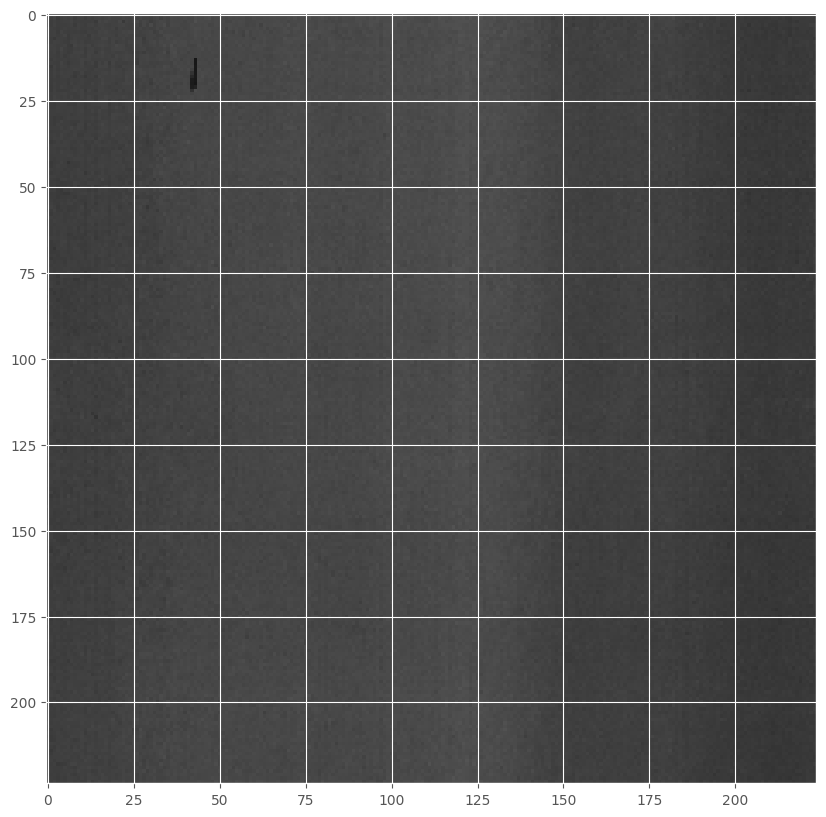

In [147]:
x=30
xml_path= '/kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/lable/inclusion (30).xml'
path= '/kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/inclusion/inclusion (30).jpg'
plot(path, xml_path)

In [130]:
tf.constant([2,2])**2

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([4, 4], dtype=int32)>